In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from simulations.utils import relative_error

def pos_part(matrix):
    return np.where(matrix > 0, matrix, 0)

def neg_part(matrix):
    return np.where(matrix < 0, -matrix, 0)

from plot_utils import cool_savefig

In [3]:
number_simulations = 1000
entropy = 42
seed = np.random.SeedSequence(entropy)

In [4]:
def get_matrix(rng):
    """
    We are only interested in Beta distributions with same concentration parameter as uniform,
    that is the same value of concentration as Beta(2*0.5, 2*0.5) = Uniform(0,1)
    """
    hyperparameter = rng.random()
    random_numbers = rng.beta(a=2.*(hyperparameter), b=2.*(1.-hyperparameter),
                             size=(100,100))
    base_random_network = 2. * (random_numbers - 0.5)
    random_mask = rng.integers(low=0, high=2, size=(100,100)).astype(float)
    result = base_random_network * random_mask
    return result

In [5]:
def pos_rel_error(matrix1, matrix2):
    return relative_error(pos_part(matrix1), pos_part(matrix2))
    
def neg_rel_error(matrix1, matrix2):
    return relative_error(neg_part(matrix1), neg_part(matrix2))

def mag_rel_error(matrix1, matrix2): 
    return relative_error(np.abs(matrix1), np.abs(matrix2))

def sign_rel_error(matrix1, matrix2): 
    return relative_error(np.sign(matrix1), np.sign(matrix2)) 

In [6]:
def more_pos_than_neg(matrix):
    num_pos = np.sum(matrix > 0)
    num_neg = np.sum(matrix < 0)
    
    return num_pos > num_neg

# The idea here is to ignore at least for now those matrices with num_pos == num_neg

def more_neg_than_pos(matrix):
    num_pos = np.sum(matrix > 0)
    num_neg = np.sum(matrix < 0)
    
    return num_neg > num_pos

In [7]:
def flare(index): return sns.color_palette("flare", 10)[index]

def plot_attack(random_matrices, attack_function, title='Attack',
                variants=["dom_rel_error", "sub_rel_error",
                         "rel_error", "mag_rel_error", "sign_rel_error"], **plot_kwargs):
    
    attacked_matrices = [(matrix, attack_function(matrix)) for matrix in random_matrices]
    pos_dom_attackeds = [pair for pair in attacked_matrices if more_pos_than_neg(pair[0])]
    neg_dom_attackeds = [pair for pair in attacked_matrices if more_neg_than_pos(pair[0])]
    attacked_matrices = pos_dom_attackeds + neg_dom_attackeds
    
    rel_error_values = {
    "dom_rel_error": np.asarray([pos_rel_error(*pair) for pair in pos_dom_attackeds] +
                              [neg_rel_error(*pair) for pair in neg_dom_attackeds]),
    "sub_rel_error": np.asarray([neg_rel_error(*pair) for pair in pos_dom_attackeds] +
                              [pos_rel_error(*pair) for pair in neg_dom_attackeds]),
    "rel_error": np.asarray([relative_error(*pair) for pair in attacked_matrices]),
    "mag_rel_error": np.asarray([mag_rel_error(*pair) for pair in attacked_matrices]),
    "sign_rel_error": np.asarray([sign_rel_error(*pair) for pair in attacked_matrices]),
    }
    rel_error_values_matrix = np.concatenate([rel_error_values[variant].reshape((-1,1)) 
                                             for variant in variants], axis=1)
    
    color_map = {"dom_rel_error": flare(0), "sub_rel_error": flare(4), "rel_error": flare(2), 
                 "mag_rel_error": flare(6), "sign_rel_error": flare(9)}
    
    variant_titles = {"dom_rel_error": "Dominant Sign Edges",
                     "sub_rel_error": "Submissive Sign Edges", "rel_error": "Relative Error", 
                     "mag_rel_error": "Magnitudes Only", "sign_rel_error": "Signs Only"}
    
    with sns.axes_style("darkgrid"):
        plt.figure(figsize=(12,8))
        ax = sns.violinplot(data=rel_error_values_matrix, cut=0, 
                            palette=[color_map[variant] for variant in variants], **plot_kwargs)
        ax.set_xticklabels([variant_titles[variant] for variant in variants], fontsize=14)
        ax.set_ylabel('Value', fontsize=18)
        ax.set_ylim(bottom=-0.05)
        ax.set_title(title, fontsize=24)
        cool_savefig(title)
    
def plot_attack_conv_comb(random_matrices, attack_function, title='Attack', **plot_kwargs):
    plot_attack(random_matrices, attack_function, title=title,
               variants=["dom_rel_error", "rel_error", "sub_rel_error"], **plot_kwargs)
    
def plot_attack_alts(random_matrices, attack_function, title='Attack', **plot_kwargs):
    plot_attack(random_matrices, attack_function, title=title, 
               variants=["rel_error", "mag_rel_error", "sign_rel_error"], 
                **plot_kwargs)

In [8]:
%%time
rng = np.random.default_rng(seed)
random_matrices = [get_matrix(rng) for simulation in range(number_simulations)]

CPU times: user 2.93 s, sys: 53.8 ms, total: 2.99 s
Wall time: 2.99 s


## Shift Attack

For a positive dominated matrix, if we shift all of the entries by a constant such that they are all negative, most of them will have their magnitudes disrupted.

The attack proceeds similarly for a negative dominated matrix. All entries now become positive.

In [9]:
def shift_attack(matrix):
    num_neg = np.sum(matrix < 0.)
    num_pos = np.sum(matrix > 0.)
    
    result = matrix.copy()
    
    if num_neg > num_pos:
        result[np.nonzero(matrix)] += 2.*np.abs(np.min(matrix, axis=None))
    if num_pos > num_neg:
        result[np.nonzero(matrix)] -= 2.*np.max(matrix, axis=None)
        
    return result

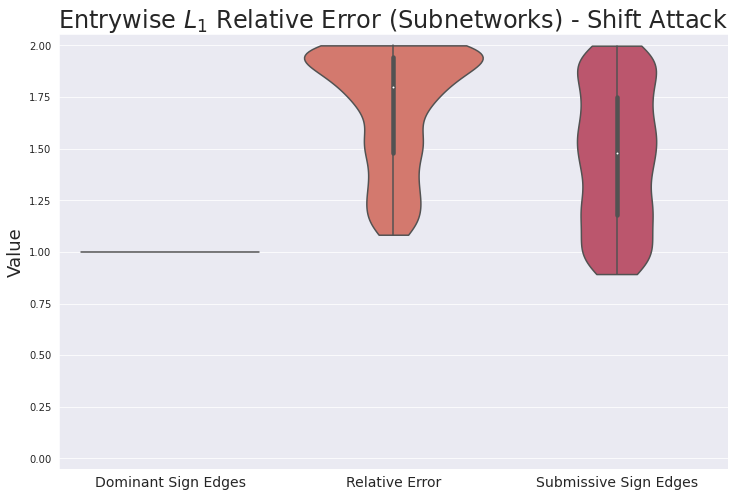

In [10]:
plot_attack_conv_comb(random_matrices, shift_attack, title='Entrywise $L_1$ Relative Error (Subnetworks) - Shift Attack')

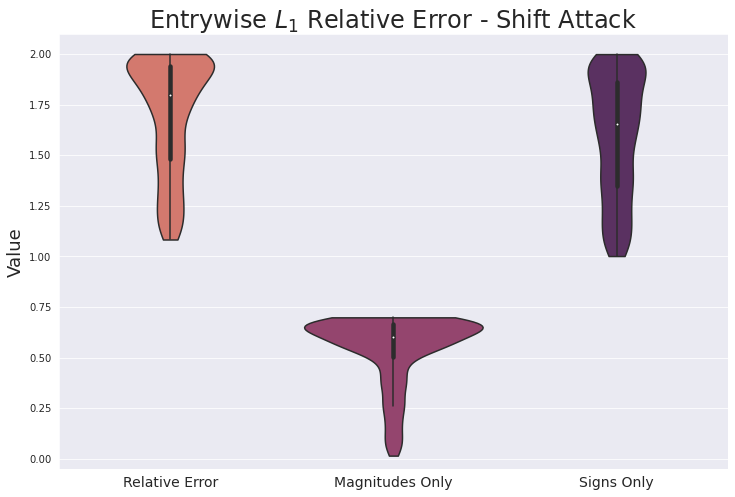

In [11]:
plot_attack_alts(random_matrices, shift_attack, title='Entrywise $L_1$ Relative Error - Shift Attack')

## Magnitude Swap Attack

Replace $n$'th largest entry of matrix (in terms of absolute value) with $n$'th smallest for all $n$ (same also as replacing $n$'th smallest with $n$'th largest for all $n$), while leaving the signs exactly the same.

In [12]:
def magnitude_attack(matrix):
    nonzero_indices = np.nonzero(matrix)
    nonzero_entries = matrix[nonzero_indices]
    
    signs = np.sign(nonzero_entries)
    magnitudes = np.abs(nonzero_entries)
    
    # note how/why (np.sort(vector))[np.argsort(np.argsort(vector))] is the same as vector
    # each entry of np.argsort(np.argsort(vector)) gives the relative size of the corresponding
    # entry of vector, for example if its `i`th entry is 7, then the `i`th entry of vector is
    # the (7+1)'th smallest. If we instead want the `i`th entry to be the (7+1)'th largest,
    # we do the following (note that [::-1] is equivalent to `np.flip` for a 1D array):
    attacked_magnitudes = (np.sort(magnitudes)[::-1])[np.argsort(np.argsort(magnitudes))]
    
    attacked_matrix = np.zeros(matrix.shape)
    attacked_matrix[nonzero_indices] = signs * attacked_magnitudes
    return attacked_matrix

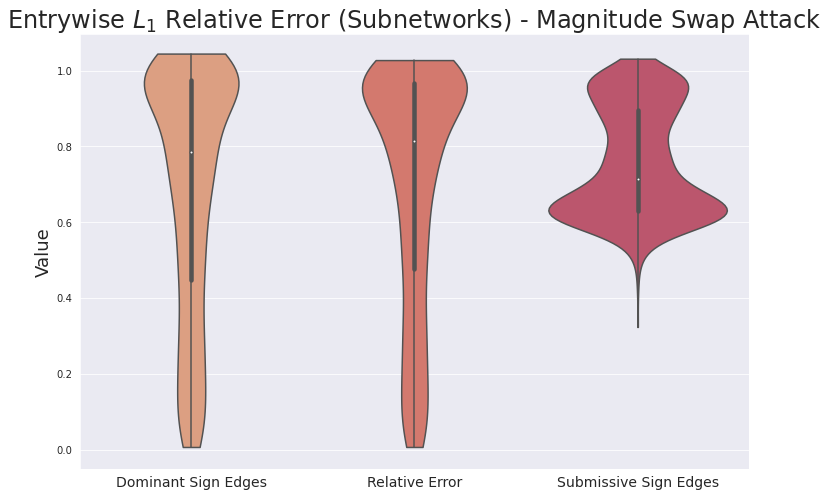

In [13]:
plot_attack_conv_comb(random_matrices, magnitude_attack, 'Entrywise $L_1$ Relative Error (Subnetworks) - Magnitude Swap Attack')

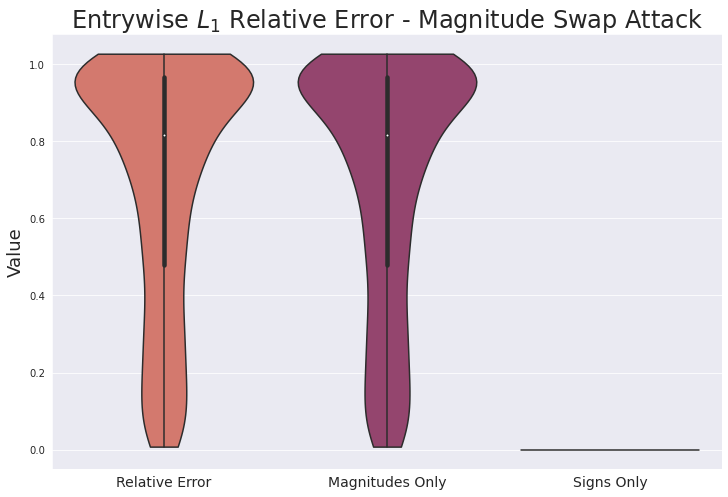

In [14]:
plot_attack_alts(random_matrices, magnitude_attack, 'Entrywise $L_1$ Relative Error - Magnitude Swap Attack')

## Sign Flip Attack

In [15]:
def sign_attack(matrix):
    num_neg = np.sum(matrix < 0)
    num_pos = np.sum(matrix > 0)
    
    # doesn't handle case where num_neg = num_pos, probably not great
    if num_neg > num_pos:
        result = np.where(matrix > 0, matrix, -matrix)
    if num_pos > num_neg:
        result = np.where(matrix < 0, matrix, -matrix)
        
    return result

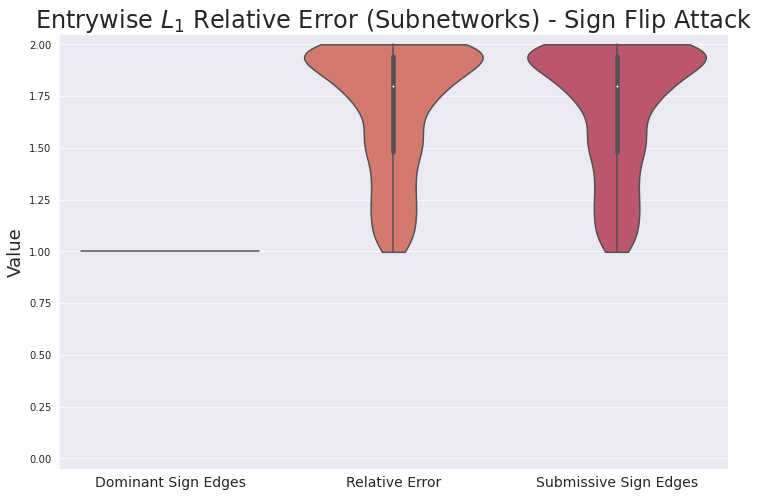

In [16]:
plot_attack_conv_comb(random_matrices, sign_attack, 'Entrywise $L_1$ Relative Error (Subnetworks) - Sign Flip Attack')

#### Interlude - Why is Contribution from Dominant Sign Edges 0?

In [18]:
    attacked_matrices = [(matrix, sign_attack(matrix)) for matrix in random_matrices]
    pos_dom_attackeds = [pair for pair in attacked_matrices if more_pos_than_neg(pair[0])]
    neg_dom_attackeds = [pair for pair in attacked_matrices if more_neg_than_pos(pair[0])]

In [20]:
test = pos_dom_attackeds[0][0]

In [21]:
np.sum(np.abs(test))

3305.287529974765

In [39]:
np.sum(pos_part(test))

3032.1141544824095

In [23]:
np.sum(pos_part(test)) / np.sum(np.abs(test))

0.9173526136485798

In [25]:
pos_rel_error(*pos_dom_attackeds[0])

1.0

In [26]:
neg_rel_error(*pos_dom_attackeds[0])

1.8347052272971598

In [28]:
np.sum(neg_part(test)) / np.sum(np.abs(test))

0.08264738635142017

In [29]:
np.sum(neg_part(test)) / np.sum(np.abs(test)) * neg_rel_error(*pos_dom_attackeds[0])

0.15163359176139854

In [30]:
(np.sum(neg_part(test)) / np.sum(np.abs(test)) * neg_rel_error(*pos_dom_attackeds[0])) + (np.sum(pos_part(test)) / np.sum(np.abs(test)))

1.0689862054099784

In [32]:
relative_error(*pos_dom_attackeds[0])

1.8347052272971596

OK yeah, this actually can't be right -- something is wrong here -- both my formula and my code implementation can't be correct...

In [33]:
test_attack = pos_dom_attackeds[0][1]

In [34]:
np.sum(np.abs(test - test_attack))

6064.228308964819

In [35]:
np.sum(np.abs(test - test_attack)) / (np.sum(np.abs(test)))

1.8347052272971596

ok it looks like my formula must be wrong then?????

In [36]:
np.sum(np.abs(pos_part(test) - pos_part(test_attack)))

3032.1141544824095

In [37]:
np.sum(np.abs(neg_part(test) - neg_part(test_attack)))

3032.1141544824095

_interesting_....

In [38]:
(np.sum(np.abs(pos_part(test) - pos_part(test_attack)))) + (np.sum(np.abs(neg_part(test) - neg_part(test_attack))))

6064.228308964819

ok so that maybe seems to be the explanation? it is a convex combination of the same number, so the result is the same number? or what?

In [40]:
2 * (np.sum(pos_part(test)) / np.sum(np.abs(test)))

1.8347052272971596

ooh, _very_ interesting...

In [42]:
(np.sum(neg_part(test)) / np.sum(np.abs(test)))

0.08264738635142017

In [43]:
(np.sum(neg_part(test)) / np.sum(np.abs(test))) * (np.sum(np.abs(neg_part(test) - neg_part(test_attack)))) / np.sum(neg_part(test))

0.9173526136485798

In [45]:
(np.sum(np.abs(neg_part(test) - neg_part(test_attack)))) / np.sum(np.abs(neg_part(test)))

11.09959617776608

wait then isn't this the negative relative error? why is this not 

In [44]:
relative_error(neg_part(test), neg_part(test_attack))

1.8347052272971598

OK so actually something _isn't_ right then -- this is like the negative relative error multiplied by the proportion of entries in the negative part

oh so the problem seems like how the `relative_error` function in my code actually normalizes the matrices before computing their relative errors -- so like this is basically just entirely wrong

AGH what

ok I get why I would want to normalize the _estimates_ before computing their relative error with respect to the truth, but this is honestly ridiculous/premature imo

AGH OK anyway though it does explain why these graphs seem so off....

Anyway I changed the code to not normalize beforehand and the graphs actually look _way_ worse -- basically not much "numerical stability" given how small the magnitude of the submissive sign subnetwork can be. So this is probably better, I will just be sure to mention in the methods that the matrices were entrywise $L_1$ normalized first, even though in this case we don't really have the convex combination property but whatever.

#### End Interlude

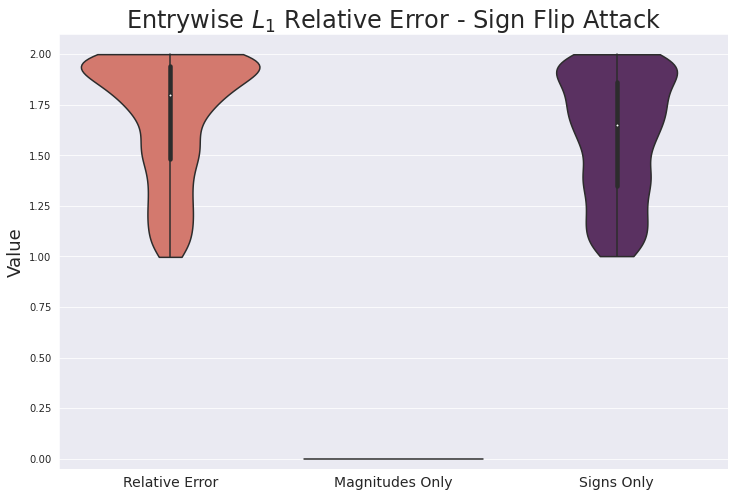

In [17]:
plot_attack_alts(random_matrices, sign_attack, 'Entrywise $L_1$ Relative Error - Sign Flip Attack')